Build a collaborative filtering recommendation system using ALS algorithm.

In [1]:
import os
import time
import pickle
import logging
from zipfile import ZipFile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
from implicit.evaluation import train_test_split, mean_average_precision_at_k, ndcg_at_k, AUC_at_k

logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")

### Dataset

In [2]:
BASE_DIR =  os.path.join(os.path.dirname(os.path.realpath('__file__')), 'dev-data') 

In [3]:
data_file = f"{BASE_DIR}/ml-latest-small.zip"

# Extract files
with ZipFile(data_file, "r") as zip:
    print("Extracting all the files now...")
    zip.extractall(path=f"{BASE_DIR}/")
    print("Done!")

Extracting all the files now...
Done!


In [4]:
# Read csv file
ratings = pd.read_csv(f"{BASE_DIR}/ml-latest-small/ratings.csv")
movies = pd.read_csv(f"{BASE_DIR}/ml-latest-small/movies.csv")

In [5]:
movies.rename(columns={'movieId': 'movie_id'}, inplace=True)
movies.head(2)

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [6]:
movie_genre = [x.split("|") for x in movies["genres"]]
movie_genre

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Adventure', 'Children', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy'],
 ['Action', 'Crime', 'Thriller'],
 ['Comedy', 'Romance'],
 ['Adventure', 'Children'],
 ['Action'],
 ['Action', 'Adventure', 'Thriller'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy', 'Horror'],
 ['Adventure', 'Animation', 'Children'],
 ['Drama'],
 ['Action', 'Adventure', 'Romance'],
 ['Crime', 'Drama'],
 ['Drama', 'Romance'],
 ['Comedy'],
 ['Comedy'],
 ['Action', 'Comedy', 'Crime', 'Drama', 'Thriller'],
 ['Comedy', 'Crime', 'Thriller'],
 ['Crime', 'Drama', 'Horror', 'Mystery', 'Thriller'],
 ['Action', 'Crime', 'Thriller'],
 ['Drama', 'Sci-Fi'],
 ['Drama', 'Romance'],
 ['Drama'],
 ['Children', 'Drama'],
 ['Drama', 'Romance'],
 ['Adventure', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi'],
 ['Crime', 'Drama'],
 ['Drama'],
 ['Mystery', 'Sci-Fi', 'Thriller'],
 ['Children', 'Drama'],
 ['Crime', 'Drama'],
 ['Children', 'Comedy'],
 

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  9742 non-null   int64 
 1   title     9742 non-null   object
 2   genres    9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [7]:
ratings.rename(columns={'userId': 'user_id', 'movieId': 'movie_id'}, inplace=True)
ratings.head(2)

,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100836 non-null  int64  
 1   movie_id   100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### Data Cleaning & Exploration

In [9]:
# ratings dataset should have movies only which exist in our movies dataset
# it's ok...
ratings = ratings[ratings.movie_id.isin(movies.movie_id)]
ratings.shape

(100836, 4)

In [10]:
df = ratings.merge(movies[['movie_id', 'title', 'genres']], how='left', on='movie_id')
df.head()

,user_id,movie_id,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100836 non-null  int64  
 1   movie_id   100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [12]:
# Null value
df[df.isna().any(axis=1)]

,user_id,movie_id,rating,timestamp,title,genres


In [13]:
# Dublicate rows
df[df.duplicated()]

,user_id,movie_id,rating,timestamp,title,genres


In [14]:
logger.info(f'The unique number of users: {df["user_id"].nunique()}')
logger.info(f'The unique number of movies: {df["movie_id"].nunique()}')

2023-10-17 16:08:38,401 : INFO : The unique number of users: 610
2023-10-17 16:08:38,403 : INFO : The unique number of movies: 9724


Explore the genre of movies

In [15]:
genres = pd.DataFrame(df.genres.str.split('|').tolist()).stack().unique()
genres = pd.DataFrame(genres, columns=['genre']) 
movies_df = movies.join(movies.genres.str.get_dummies().astype(bool))
movies_df.drop('genres', inplace=True, axis=1)
movies_df.head(2)

,movie_id,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),False,False,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


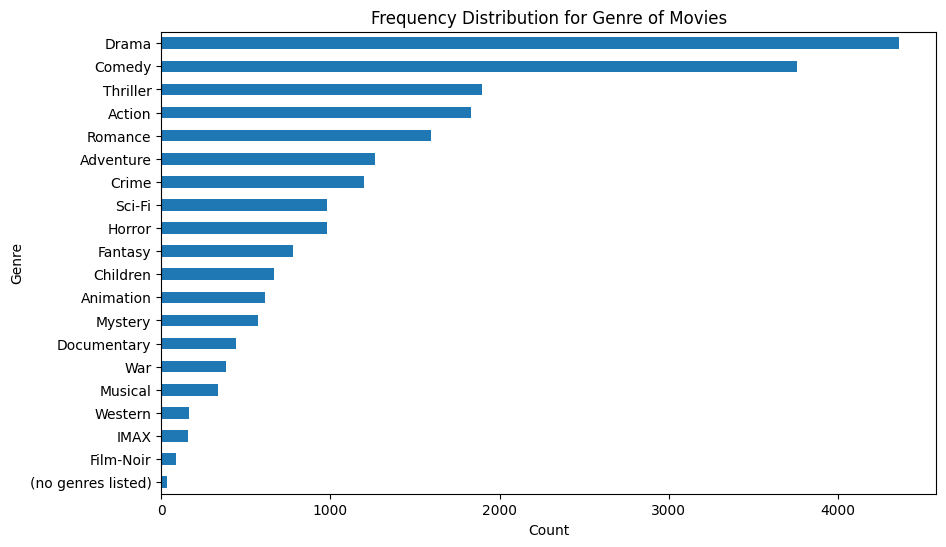

In [16]:
genre_counts = movies_df.iloc[:, 2:].sum()
genre_counts = genre_counts.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='barh')
plt.title('Frequency Distribution for Genre of Movies')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [17]:
df[df['genres'].str.contains('IMAX', case=False, na=False)].head()

,user_id,movie_id,rating,timestamp,title,genres
240,2,58559,4.5,1445715141,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
246,2,79132,4.0,1445714841,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
251,2,91529,3.5,1445714891,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX
255,2,109487,3.0,1445715145,Interstellar (2014),Sci-Fi|IMAX
340,4,595,3.0,986848609,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX


Explore the year of movies

In [18]:
df['year'] = df['title'].str.extract(r'\((\d{4})\)', expand=True)
df['title'] = df['title'].str.replace(r'\(\d{4}\)', '')
df.head(2)

,user_id,movie_id,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,964981247,Grumpier Old Men,Comedy|Romance,1995


In [19]:
df.info() #20 years are null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100836 non-null  int64  
 1   movie_id   100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
 6   year       100818 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 6.2+ MB


In [20]:
mean_year = round(df['year'].astype(float).mean(),0)
df['year'] = df['year'].astype(float).fillna(mean_year).astype(int)
mean_year

1994.0

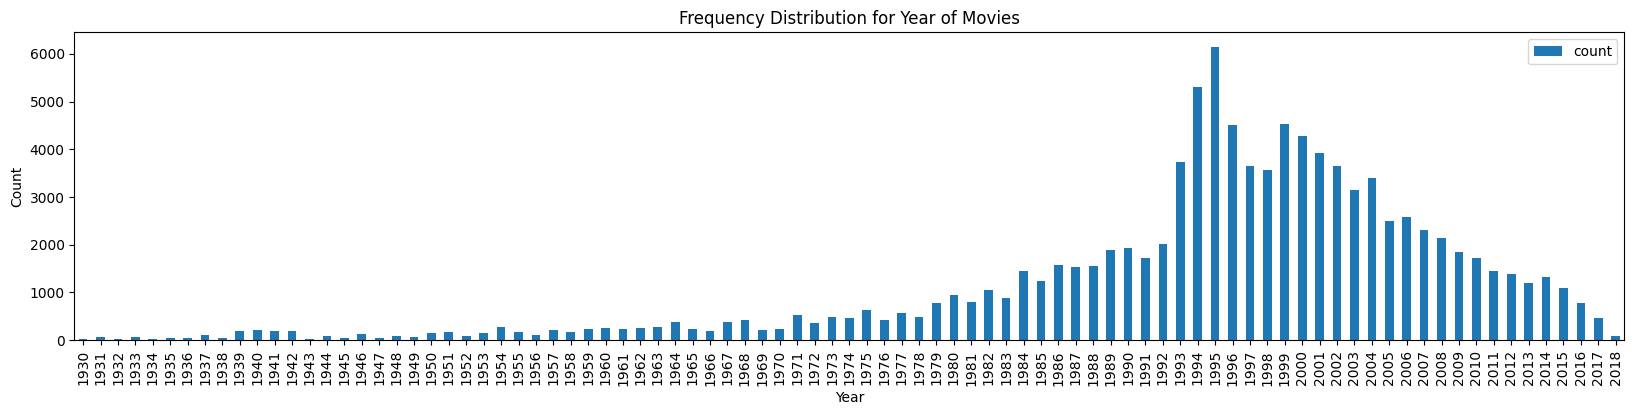

In [21]:
year = df.groupby(['year']).agg({
    'year': [('count')]
})

year.columns = year.columns.droplevel(level=0)
year = year.sort_values(by='year', ascending=True)
year_1 = year[year.index >= 1930]

fig, ax = plt.subplots(figsize=(20, 4))
year_1.plot(kind='bar', ax= ax)
plt.title('Frequency Distribution for Year of Movies')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

Explore the rating

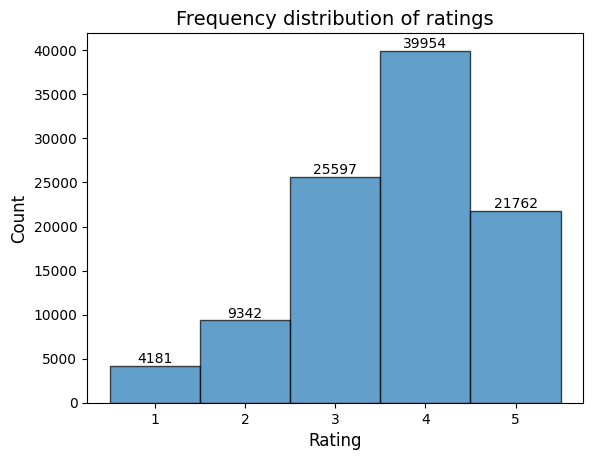

In [22]:
# Specify the number of bins and calculate bin edges
num_bins = 5  # You can adjust this as needed
hist, bin_edges = np.histogram(df['rating'], bins=num_bins)

# Calculate the bin widths
bin_width = bin_edges[1] - bin_edges[0]

# Calculate the bin midpoints
bin_midpoints = bin_edges[:-1] + bin_width / 2

# Create a histogram with the specified bins and widths
plt.hist(df['rating'], bins=bin_edges, width=bin_width, alpha=0.7, edgecolor='black')

# Add labels to the bars
for i in range(len(bin_edges) - 1):
    plt.text(
        bin_midpoints[i],  # x-coordinate for the label (bin midpoint)
        hist[i],  # y-coordinate for the label (height of the bar)
        str(round(hist[i])),  # Text to display (count in the bin)
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

# Set the title and axis labels
plt.title('Frequency distribution of ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set x-axis tick positions to the bin midpoints
plt.xticks(bin_midpoints, [int(round(x,0)) for x in bin_midpoints])

# Display the plot
plt.show()

In [23]:
# Calculate number rating by movie_id
nbr_rating = pd.DataFrame(df.groupby('rating')['rating'].count())
nbr_rating.rename(columns={'rating': 'cnt_rating'}, inplace=True)
nbr_rating

,cnt_rating
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Explore the average rating by movie

In [24]:
# Calculate number rating by movie_id
avg_rating = pd.DataFrame(df.groupby('movie_id')['rating'].mean())
avg_rating.rename(columns={'rating': 'avg_rating'}, inplace=True)
avg_rating.head(2)

,avg_rating
movie_id,
1,3.920930
2,3.431818


In [25]:
# 25% of the average rating for movie are equal or less of 2.8
avg_rating.describe(percentiles=[.25, .5, .75, .95, 1])

,avg_rating
count,9724.000000
mean,3.262448
std,0.869874
min,0.500000
25%,2.800000
50%,3.416667
75%,3.911765
95%,4.500000
100%,5.000000
max,5.000000


In [26]:
df = avg_rating.merge(df, how='left', on='movie_id')
df.head(5)

,movie_id,avg_rating,user_id,rating,timestamp,title,genres,year
0,1,3.92093,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3.92093,5,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,1,3.92093,7,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,1,3.92093,15,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,1,3.92093,17,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


In [27]:
# create column group_flag for highlight group (0 or 1)
df['group_flag'] = np.where(df['avg_rating'] <= 2.8, 1, 0)
df.drop(columns=['timestamp'], inplace=True)
df.head()

,movie_id,avg_rating,user_id,rating,title,genres,year,group_flag
0,1,3.92093,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0
1,1,3.92093,5,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0
2,1,3.92093,7,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0
3,1,3.92093,15,2.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0
4,1,3.92093,17,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0


In [28]:
df[df['avg_rating'] <= 2.8].tail()

,movie_id,avg_rating,user_id,rating,title,genres,year,group_flag
100819,190207,1.5,338,1.5,Tilt,Drama|Romance,2011,1
100821,190213,1.0,338,1.0,John From,Drama,2015,1
100822,190215,1.5,338,1.5,Liquid Truth,Drama,2017,1
100823,190219,1.0,338,1.0,Bunny,Animation,1998,1
100824,190221,1.0,338,1.0,Hommage à Zgougou (et salut à Sabine Mamou),Documentary,2002,1


Explore the density of movies ratings

In [29]:
mov = df.groupby(['movie_id']).agg({
    'movie_id': [('count')]
})

mov.columns = mov.columns.droplevel(level=0)
mov.sort_values(by='count', ascending=False).head()

,count
movie_id,
356,329
318,317
296,307
593,279
2571,278


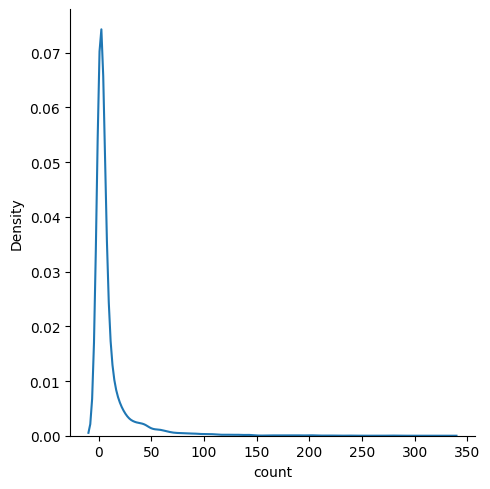

In [30]:
sns.displot(mov['count'], kind='kde')

Normalize the ratings to check if better result

In [31]:
# Normalize Ratings

# Define the desired range [a, b]
a = 0.001  # Minimum value
b = 0.999  # Maximum value

# Calculate min and max of the data
min_value = min(df['rating'])
max_value = max(df['rating'])

df['rating_std'] = df['rating'].apply(lambda x: a + (x - min_value) * (b - a) / (max_value - min_value))
df.head()

,movie_id,avg_rating,user_id,rating,title,genres,year,group_flag,rating_std
0,1,3.92093,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0,0.777222
1,1,3.92093,5,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0,0.777222
2,1,3.92093,7,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0,0.888111
3,1,3.92093,15,2.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0,0.444556
4,1,3.92093,17,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0,0.888111


### Train & Evaluation

In [32]:
# for the evaluation, remove the group_flag = 0 (not for the training)
df_pred = df[df["group_flag"] == 0]
print(df.shape, df_pred.shape)

(100836, 9) (89915, 9)


In [33]:
# Convert dataset into a csr sparse matrix with users x items format

df['user_id'] = df['user_id'].astype('category')
df['movie_id'] = df['movie_id'].astype('category')

df_pred['user_id'] = df_pred['user_id'].astype('category')
df_pred['movie_id'] = df_pred['movie_id'].astype('category')

In [34]:
# Convert dataset into a csr sparse matrix with users x items format

user_item_data = csr_matrix(
    (df['rating'].astype(np.float32), (df['user_id'].cat.codes.copy(), df['movie_id'].cat.codes.copy())), 
    dtype=np.float32,
)

user_item_data_std = csr_matrix(
    (df['rating_std'].astype(np.float32), (df['user_id'].cat.codes.copy(), df['movie_id'].cat.codes.copy())), 
    dtype=np.float32,
)

user_item_data_pred = csr_matrix(
    (df_pred['rating'].astype(np.float32), (df_pred['user_id'].cat.codes.copy(), df_pred['movie_id'].cat.codes.copy())), 
    dtype=np.float32,
)

user_item_data

<610x9724 sparse matrix of type '<class 'numpy.float32'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [35]:
user_item_data_std

<610x9724 sparse matrix of type '<class 'numpy.float32'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [36]:
df.shape

(100836, 9)

In [37]:
user_item_data_pred

<610x7274 sparse matrix of type '<class 'numpy.float32'>'
	with 89915 stored elements in Compressed Sparse Row format>

In [38]:
user_item_data[1].data

array([3. , 4. , 4.5, 4. , 4. , 3.5, 4. , 4. , 4.5, 5. , 4.5, 3. , 4. ,
       3. , 4. , 4.5, 5. , 4. , 5. , 3.5, 2.5, 3.5, 5. , 3. , 4. , 2. ,
       3.5, 5. , 5. ], dtype=float32)

In [39]:
user_item_data_std[1].data

array([0.5554444 , 0.7772222 , 0.8881111 , 0.7772222 , 0.7772222 ,
       0.6663333 , 0.7772222 , 0.7772222 , 0.8881111 , 0.999     ,
       0.8881111 , 0.5554444 , 0.7772222 , 0.5554444 , 0.7772222 ,
       0.8881111 , 0.999     , 0.7772222 , 0.999     , 0.6663333 ,
       0.44455555, 0.6663333 , 0.999     , 0.5554444 , 0.7772222 ,
       0.33366665, 0.6663333 , 0.999     , 0.999     ], dtype=float32)

In [67]:
# Iteration for find best hyperparameter
for i in [1]:

    # weight the matrix, both to reduce impact of users that have interact with the same items (not in case here)
    # and to reduce the weight given to popular items
    item_user_data_bm25 = bm25_weight(user_item_data.T, K1=1, B=0.25) 
    user_item_data_bm25 = item_user_data_bm25.T.tocsr() 
    
    # Initialization
    models = {"als": AlternatingLeastSquares}  
    params = {'als': {'factors': 16, 'iterations': 30, 'regularization': 0.5, 'random_state':0}}
    
    # ALS 
    model_name = 'als'
    als_model = models.get(model_name)(**params.get(model_name))
    
    # Evaluation
    train, test = train_test_split( # function from evaluation in github
        user_item_data_bm25, 
        train_percentage=0.8, 
        random_state=0 # reproduce result
    )
    assert train.shape[0] == test.shape[0] == user_item_data_bm25.shape[0]
    assert train.data.shape[0] + test.data.shape[0] == user_item_data_bm25.data.shape[0]
    

    als_model.fit(train, show_progress=False)
    map_at_k = mean_average_precision_at_k( # MAP@K (have also ndcg_at_k and AUC_at_k in evaluation on github
        model=als_model, 
        train_user_items=train, 
        test_user_items=test, # then evaluate with the test set
        K=10,
        show_progress=False, 
        num_threads=1
    )
    logger.info(f'With BM25 and without movies average < 2.8, MAP@10: {map_at_k}')

2023-10-17 17:12:17,710 : INFO : With BM25 and without movies average < 2.8, MAP@10: 0.21245907757456353


In [68]:
train

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 80635 stored elements in Compressed Sparse Row format>

In [69]:
test

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 20201 stored elements in Compressed Sparse Row format>

**Iterations for hyper parameters:**

- Without BM25 and without normalization:  MAP@10 (%): **21.4**
- Without BM25 and with normalization: MAP@10 (%): 19.8

**Whitout BM25:**
- Factors: 8, **16**, 32, 64, 128 --> MAP@10 (%): 18.7, **21.4**, 20.3, 18.1, 13.4
- Iterations: 15, 20, **30**, 50, 100 --> MAP@10 (%): 21.2, 21.4, **21.5**, 21.4, 21.4
- Regularization: **0.5**, 0.1, 0.05, 0.01 --> MAP@10 (%): **21.5**, 21.3, 21.3, 21.3
- Without average movies <= 2.8 --> MAP@10 (%): **21.9**

**With BM25:**
- K1: 1, 10, 50, 100, 150, 200 --> MAP@10 (%): 21.2, 19.0, 18.6, 18.5, 18.4, 18.4
- B: 0.25, 0.5, 0.5, 0.75, 1 --> MAP@10 (%): 21.2, 20.8, 20.8, 20.3, 19.4
- Without average movies <= 2.8 --> MAP@10 (%): 21.3

In [64]:
#Final model with all score after my choice of hyper parameters 
    
# Initialization
models = {"als": AlternatingLeastSquares}  
params = {'als': {'factors': 16, 'iterations': 30, 'regularization': 0.5, 'random_state':0}}
    
# ALS 
model_name = 'als'
als_model = models.get(model_name)(**params.get(model_name))
    
# Evaluation
train, test = train_test_split( # function from evaluation in github
    user_item_data_pred, 
    train_percentage=0.8, 
    random_state=0 # reproduce result
)
assert train.shape[0] == test.shape[0] == user_item_data_pred.shape[0]
assert train.data.shape[0] + test.data.shape[0] == user_item_data_pred.data.shape[0]
    
start = time.time()
als_model.fit(train, show_progress=False)
end = time.time()
logger.info(f'The training time: {(end - start) } seconds')

2023-10-17 17:11:39,838 : INFO : The training time: 0.16756916046142578 seconds


In [65]:
train

<610x7274 sparse matrix of type '<class 'numpy.float32'>'
	with 71953 stored elements in Compressed Sparse Row format>

In [66]:
test

<610x7274 sparse matrix of type '<class 'numpy.float32'>'
	with 17962 stored elements in Compressed Sparse Row format>

In [42]:
start = time.time()
map_at_k = mean_average_precision_at_k( # MAP@K (have also ndcg_at_k and AUC_at_k in evaluation on github
    model=als_model, 
    train_user_items=train, 
    test_user_items=test, # then evaluate with the test set
    K=10,
    show_progress=False, 
    num_threads=1
)
end = time.time()
logger.info(f'The evaluation time: {(end - start) } seconds')
logger.info(f'MAP@10: {map_at_k}')

2023-10-17 16:08:40,251 : INFO : The evaluation time: 0.09305977821350098 seconds
2023-10-17 16:08:40,254 : INFO : MAP@10: 0.21932392122142652


In [43]:
# With ndcg_at_k to compare 
start = time.time()
ndcg_result = ndcg_at_k(
    model=als_model, 
    train_user_items=train, 
    test_user_items=test, 
    K=10, 
    show_progress=False, 
    num_threads=1
)
end = time.time()
logger.info(f'The evaluation time: {(end - start) } seconds')
logger.info(f'NDCG@10: {ndcg_result}')

2023-10-17 16:08:40,333 : INFO : The evaluation time: 0.059793949127197266 seconds
2023-10-17 16:08:40,335 : INFO : NDCG@10: 0.33974557924604093


In [44]:
# With auc_at_k to compare 
start = time.time()
AUC_result = AUC_at_k(
    model=als_model, 
    train_user_items=train, 
    test_user_items=test, 
    K=10, 
    show_progress=False, 
    num_threads=1
)
end = time.time()
logger.info(f'The evaluation time: {(end - start) } seconds')
logger.info(f'AUC@10: {AUC_result}')

2023-10-17 16:08:40,400 : INFO : The evaluation time: 0.055709123611450195 seconds
2023-10-17 16:08:40,401 : INFO : AUC@10: 0.587354992368309


In [45]:
# Create mapping dictionaries

user_dict = dict((v, k) for k, v in dict(enumerate(df['user_id'].cat.categories)).items())
item_dict = dict(enumerate(df['movie_id'].cat.categories))

In [46]:
# convert into pandas dataframe (movies)

items_df = pd.DataFrame(item_dict, index=['movie_id']).T    
items_df.reset_index(inplace=True)
items_df.rename(columns={'index': 'id'}, inplace=True)
items_df.head()

,id,movie_id
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


In [47]:
# convert into pandas dataframe (users)

users_df = pd.DataFrame(dict(enumerate(df['user_id'].cat.categories)), index=['user_id']).T    
users_df.reset_index(inplace=True)
users_df.rename(columns={'index': 'id'}, inplace=True)
users_df.head()

,id,user_id
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5


In [70]:
# Training
# Train the ALS model on the entire dataset (not just on the train subset)
# We want to have the maximum amount of data to capture all the paterns in the dataset.

model_name = 'als'
als_model = models.get(model_name)(**params.get(model_name))
als_model.fit(user_item_data, show_progress=True)

# Model serialization 
training_output = {
    "users_df": users_df,
    "items_df": items_df,
    'model': als_model
}

# we can save on AWS / GCP / Azure Bucket also
with open(f'{BASE_DIR}/model/training_output.pkl', 'wb') as f:
    pickle.dump(training_output, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

  0%|          | 0/30 [00:00<?, ?it/s]

In [71]:
user_item_data

<610x9724 sparse matrix of type '<class 'numpy.float32'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [49]:
# Model artifact

logger.info(f'Users embedding shape : {als_model.user_factors.shape}')
logger.info(f'Movies embedding shape : {als_model.item_factors.shape}')

2023-10-17 16:08:40,924 : INFO : Users embedding shape : (610, 16)
2023-10-17 16:08:40,924 : INFO : Movies embedding shape : (9724, 16)


### Inference

In [50]:
# Initialize model
with open(os.path.join(f'{BASE_DIR}/model/', 'training_output.pkl'), 'rb') as f:
    training_output = pickle.load(f)
f.close()

#training_output
als_model = training_output['model']
users_df = training_output['users_df']
items_df = training_output['items_df']

### Presonalized Recommendation Systems

Use-Case: Single user prediction - Static history & with filtered movies & without liked movies included

In [51]:
# Create a list of extra articles to filter out from personalized lists

item_to_filter = df[df['group_flag'] == 1]['movie_id'].unique()
#logger.info(f'The number of items to filter: {len(item_to_filter)}')
rev_item_dict = dict((v, k) for k, v in item_dict.items())
item_to_filter = [rev_item_dict[item] for item in item_to_filter]

In [52]:
user_id = 2

logger.info(f'user_id: {user_id}')
logger.info(f'The number of rating movies: {len(df[df["user_id"] == user_id])}')
logger.info(f'The number of the user rating movies <= 2.8: {len(df[(df["user_id"] == user_id) & (df["rating"] <= 2.8)])}')

customer_id = user_dict[user_id]

start = time.time()
ids, scores = als_model.recommend(
        userid=customer_id,
        user_items=user_item_data[customer_id],
        N=10,
        filter_already_liked_items=True, 
        filter_items=item_to_filter,
        recalculate_user=False
)
end = time.time()
logger.info(f'The elapsed time: {(end - start) * 1000} milliseconds')

ids_df = pd.DataFrame(ids.T, columns=[user_id])
ids_df = pd.melt(ids_df, var_name='user_id', value_name='id')

scores_df = pd.DataFrame(scores.T, columns=[user_id])
scores_df = pd.melt(scores_df, var_name='user_id', value_name='score')

usecase_1 = pd.concat([ids_df, scores_df[['score']]], axis=1)
usecase_1 = usecase_1.set_index(['id'])
usecase_1['movie_id'] = items_df['movie_id']
usecase_1 = pd.merge(
    usecase_1, 
    movies[['movie_id', 'title', 'genres']], 
    how='left', 
    on='movie_id'
)

2023-10-17 16:08:40,949 : INFO : user_id: 2
2023-10-17 16:08:40,951 : INFO : The number of rating movies: 29
2023-10-17 16:08:40,952 : INFO : The number of the user rating movies <= 2.8: 2
2023-10-17 16:08:40,957 : INFO : The elapsed time: 4.889011383056641 milliseconds


In [53]:
# customer history 
df[df['user_id'] == user_id][['user_id', 'movie_id', 'rating', 'avg_rating', 'title', 'genres', 'year']]

,user_id,movie_id,rating,avg_rating,title,genres,year
8652,2,318,3.0,4.429022,"Shawshank Redemption, The",Crime|Drama,1994
9186,2,333,4.0,3.780000,Tommy Boy,Comedy,1995
34762,2,1704,4.5,4.078014,Good Will Hunting,Drama|Romance,1997
55517,2,3578,4.0,3.938235,Gladiator,Action|Adventure|Drama,2000
72615,2,6874,4.0,3.961832,Kill Bill: Vol. 1,Action|Crime|Thriller,2003
76949,2,8798,3.5,3.761364,Collateral,Action|Crime|Drama|Thriller,2004
82940,2,46970,4.0,3.250000,Talladega Nights: The Ballad of Ricky Bobby,Action|Comedy,2006
83508,2,48516,4.0,4.252336,"Departed, The",Crime|Drama|Thriller,2006
86868,2,58559,4.5,4.238255,"Dark Knight, The",Action|Crime|Drama|IMAX,2008
87775,2,60756,5.0,3.553571,Step Brothers,Comedy,2008


In [54]:
# recommendation for 10 movies
usecase_1

,user_id,score,movie_id,title,genres
0,2,0.488009,2959,Fight Club (1999),Action|Crime|Drama|Thriller
1,2,0.432622,80463,"Social Network, The (2010)",Drama
2,2,0.423072,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,2,0.419995,68954,Up (2009),Adventure|Animation|Children|Drama
4,2,0.408798,356,Forrest Gump (1994),Comedy|Drama|Romance|War
5,2,0.397518,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6,2,0.396792,2329,American History X (1998),Crime|Drama
7,2,0.390185,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
8,2,0.389275,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
9,2,0.386336,858,"Godfather, The (1972)",Crime|Drama


### Non-presonalized Recommendation Systems

Use-Case: Item to Item recommendation

In [55]:
movie_id = 6874

# get related items for Kill Bill: Vol. 1 (movie_id = 6874)
item_id = rev_item_dict[movie_id]

start = time.time()
ids, scores = als_model.similar_items(
    itemid=item_id, 
    N=6, 
)
end = time.time()
logger.info(f'The elapsed time: {(end - start) * 1000} milliseconds')

ids_df = pd.DataFrame(ids[1:].T, columns=[movie_id])
ids_df = pd.melt(ids_df, var_name='movie_id', value_name='id')

scores_df = pd.DataFrame(scores[1:].T, columns=[movie_id])
scores_df = pd.melt(scores_df, var_name='movie_id', value_name='score')

usecase_2 = pd.concat([ids_df, scores_df[['score']]], axis=1)
usecase_2 = usecase_2.set_index(['id'])
usecase_2['movie_id'] = items_df['movie_id']
usecase_2 = pd.merge(
    usecase_2, 
    movies[['movie_id', 'title', 'genres']], 
    how='left', 
    on='movie_id'
)

2023-10-17 16:08:41,210 : INFO : The elapsed time: 3.4399032592773438 milliseconds


In [56]:
# the movie
movies[movies['movie_id'] == movie_id]

,movie_id,title,genres
4615,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller


In [57]:
# recommendation for 5 movies
usecase_2

,movie_id,score,title,genres
0,7438,0.989659,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller
1,32587,0.968508,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller
2,44191,0.962429,V for Vendetta (2006),Action|Sci-Fi|Thriller|IMAX
3,7361,0.949874,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
4,48780,0.938919,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller
